# Articles
https://keras.io/guides/transfer_learning/
https://keras.io/guides/training_with_built_in_methods/
https://www.youtube.com/watch?v=4umFSRPx-94&ab_channel=DigitalSreeni
https://www.tensorflow.org/guide/saved_model
https://github.com/UCSD-E4E/PyHa/blob/Microfaune_Retraining/Microfaune_Retraining-Copy1.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
from tensorflow import keras

In [3]:
train = True

## Load in BirdNET-Analyzer Model

In [4]:
# path to model folder, should have assets/variables/frozen pb graphs
path_to_saved_model = "./checkpoints/V2.1/BirdNET_GLOBAL_2K_V2.1_Model"

In [5]:
model = keras.models.load_model(path_to_saved_model)

In [6]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
INPUT (InputLayer)              [(None, 144000)]     0                                            
__________________________________________________________________________________________________
ADVANCED_SPEC1 (LinearSpecLayer (None, 128, 513, 1)  1           INPUT[0][0]                      
__________________________________________________________________________________________________
BNORM_SPEC_NOQUANT (BatchNormal (None, 128, 513, 1)  4           ADVANCED_SPEC1[0][0]             
__________________________________________________________________________________________________
CONV_0 (Conv2D)                 (None, 64, 257, 30)  960         BNORM_SPEC_NOQUANT[0][0]         
______________________________________________________________________________________________

## Preprocess and load data
According to `config.py` and `checkpoints/README.md` for V2.1:  
- Model training input size: 144000 = 48000 x 3 = sample rate x num chunks  
- Model training output size: 2434 = 2424 bird classes + 10 non-event classes
- Visualize using [Netron](https://netron.app/)

In [8]:
import librosa

def splitSignal(sig, rate, overlap, seconds=3.0, minlen=1.5):

    # Split signal with overlap
    sig_splits = []
    for i in range(0, len(sig), int((seconds - overlap) * rate)):
        split = sig[i:i + int(seconds * rate)]

        # End of signal?
        if len(split) < int(minlen * rate):
            break
        
        # Signal chunk too short? Fill with zeros.
        if len(split) < int(rate * seconds):
            temp = np.zeros((int(rate * seconds)))
            temp[:len(split)] = split
            split = temp
        
        sig_splits.append(split)

    return sig_splits

def readAudioData(path, overlap, sample_rate=48000):

    #print('READING AUDIO DATA...', end=' ', flush=True)

    # Open file with librosa (uses ffmpeg or libav)
    try:
        sig, rate = librosa.load(path, sr=sample_rate, mono=True, res_type='kaiser_fast')
        clip_length = librosa.get_duration(y=sig, sr=rate)
    except:
        return 0
    # Split audio into 3-second chunks
    chunks = splitSignal(sig, rate, overlap)

    print('DONE! READ', str(len(chunks)), 'CHUNKS.')

    return chunks, clip_length

import pandas as pd
import numpy as np


#TODO Add mutliple species support for ROC curves 
def annotation_chunker_no_duplicates(kaleidoscope_df, chunk_length, include_no_bird=False, bird=None):
    """
    Function that converts a Kaleidoscope-formatted Dataframe containing 
    annotations to uniform chunks of chunk_length. If there
    are mutliple bird species in the same clip, this function creates chunks
    for the more confident bird species.

    Note: if all or part of an annotation covers the last < chunk_length
    seconds of a clip it will be ignored. If two annotations overlap in 
    the same 3 second chunk, both are represented in that chunk
    Args:
        kaleidoscope_df (Dataframe)
            - Dataframe of annotations in kaleidoscope format

        chunk_length (int)
            - duration to set all annotation chunks
    Returns:
        Dataframe of labels with chunk_length duration 
        (elements in "OFFSET" are divisible by chunk_length).
    """

    #Init list of clips to cycle through and output dataframe
    #kaleidoscope_df["FILEPATH"] =  kaleidoscope_df["FOLDER"] + kaleidoscope_df["IN FILE"] 
    kaleidoscope_df['FILEPATH'] = kaleidoscope_df.loc[:,['FOLDER','IN FILE']].sum(axis=1)
    clips = kaleidoscope_df["FILEPATH"].unique()
    df_columns = {'FOLDER': 'str', 'IN FILE' :'str', 'CLIP LENGTH' : 'float64', 'CHANNEL' : 'int64', 'OFFSET' : 'float64',
                'DURATION' : 'float64', 'SAMPLE RATE' : 'int64','MANUAL ID' : 'str'}
    output_df = pd.DataFrame({c: pd.Series(dtype=t) for c, t in df_columns.items()})
    
    # going through each clip
    for clip in clips:
        clip_df = kaleidoscope_df[kaleidoscope_df["FILEPATH"] == clip]
        path = clip_df["FOLDER"].unique()[0]
        file = clip_df["IN FILE"].unique()[0]
        birds = clip_df["MANUAL ID"].unique()
        sr = clip_df["SAMPLE RATE"].unique()[0]
        clip_len = clip_df["CLIP LENGTH"].unique()[0]

        # quick data sanitization to remove very short clips
        # do not consider any chunk that is less than chunk_length
        if clip_len < chunk_length:
            continue
        potential_annotation_count = int(clip_len)//int(chunk_length)

        # going through each species that was ID'ed in the clip
        arr_len = int(clip_len*1000)
        species_df = clip_df#[clip_df["MANUAL ID"] == bird]
        human_arr = np.zeros((arr_len))
        # looping through each annotation
        #print("========================================")
        for annotation in species_df.index:
            #print(species_df["OFFSET"][annotation])
            minval = int(round(species_df["OFFSET"][annotation] * 1000, 0))
            # Determining the end of a human label
            maxval = int(
                round(
                    (species_df["OFFSET"][annotation] +
                        species_df["DURATION"][annotation]) *
                    1000,
                    0))
            # Placing the label relative to the clip
            human_arr[minval:maxval] = 1
        # performing the chunk isolation technique on the human array

        for index in range(potential_annotation_count):
            #print("=======================")
            #print("-----------------------------------------")
            #print(index)
            chunk_start = index * (chunk_length*1000)
            chunk_end = min((index+1)*chunk_length*1000,arr_len)
            chunk = human_arr[int(chunk_start):int(chunk_end)]
            if max(chunk) >= 0.5:
                #Get row data
                row = pd.DataFrame(index = [0])
                annotation_start = chunk_start / 1000

                #Handle birdnet output edge case
                #print("-------------------------------------------")
                #print(sum(clip_df["DURATION"] == 3))
                #print(sum(clip_df["DURATION"] == 3)/clip_df.shape[0])
                #print("-------------------------------------------")
                if(sum(clip_df["DURATION"] == 3)/clip_df.shape[0] == 1):
                    #print("Processing here duration")
                    overlap = (clip_df["OFFSET"]+0.5 >= (annotation_start)) & (clip_df["OFFSET"]-0.5 <= (annotation_start))
                    annotation_df = clip_df[overlap]
                    #print(annotation_start, np.array(clip_df["OFFSET"]), overlap)
                    #print(annotation_df)
                else:
                    #print("Processing here")
                    overlap = is_overlap(clip_df["OFFSET"], clip_df["OFFSET"] + clip_df["DURATION"], annotation_start, annotation_start + chunk_length)
                    #print(overlap)
                    annotation_df = clip_df[overlap]
                    #print(annotation_df)
                
                #updating the dictionary
                if ('CONFIDENCE' in clip_df.columns):
                    annotation_df = annotation_df.sort_values(by="CONFIDENCE", ascending=False)
                    row["CONFIDENCE"] = annotation_df.iloc[0]["CONFIDENCE"]
                else:
                    #The case of manual id, or there is an annotation with no known confidence
                    row["CONFIDENCE"] = 1
                row["FOLDER"] = path
                row["IN FILE"] = file
                row["CLIP LENGTH"] = clip_len
                row["OFFSET"] = annotation_start
                row["DURATION"] = chunk_length
                row["SAMPLE RATE"] = sr
                row["MANUAL ID"] = annotation_df.iloc[0]["MANUAL ID"] 
                row["CHANNEL"] = 0
                output_df = pd.concat([output_df,row], ignore_index=True)
            elif(include_no_bird):
                #print(max(chunk))
                #Get row data
                row = pd.DataFrame(index = [0])
                annotation_start = chunk_start / 1000

                #updating the dictionary
                row["CONFIDENCE"] = 0
                row["FOLDER"] = path
                row["IN FILE"] = file
                row["CLIP LENGTH"] = clip_len
                row["OFFSET"] = annotation_start
                row["DURATION"] = chunk_length
                row["SAMPLE RATE"] = sr
                row["MANUAL ID"] = "no bird"
                row["CHANNEL"] = 0
                output_df = pd.concat([output_df,row], ignore_index=True)
    
    return output_df


def is_overlap(offset_df, end_df, chunk_start, chunk_end):
    is_both_before = (chunk_end < offset_df) & (chunk_start < offset_df)
    is_both_after = (end_df < chunk_end) & (end_df < chunk_start)
    return (~is_both_before) & (~is_both_after)
    
    
    interval = pd.Interval(left=offset_df, right=end_df)
    print(interval)


def split_save_files(dataframe_of_data):
    chunked_df = annotation_chunker_no_duplicates(dataframe_of_data, 3, include_no_bird=True)
    
    
    chunked_df.apply()
    



In [9]:
chunks,clip_length  = readAudioData("./Data/code-testing/XC628854 - Yellow-olive Flatbill - Tolmomyias sulphurescens.mp3", 0, sample_rate=48000)

DONE! READ 39 CHUNKS.


In [10]:
import pandas as pd
data = pd.read_csv("C:/Users/Siloux/Desktop/E4E/passive-acoustic-biodiversity/TweetyNET/cosmos_data/cosmos_random_sample_processing/automated_cosmos_tweety_to_birdnet.csv")
chunked_df = annotation_chunker_no_duplicates(data, 3, include_no_bird=True)
chunked_df

,FOLDER,IN FILE,CLIP LENGTH,CHANNEL,OFFSET,DURATION,SAMPLE RATE,MANUAL ID,CONFIDENCE
0,.\..\Cosmos_data\,XC100027 - Southern Nightingale-Wren - Microce...,81.528167,0,0.0,3.0,48000,Microcerculus marginatus,0.155038
1,.\..\Cosmos_data\,XC100027 - Southern Nightingale-Wren - Microce...,81.528167,0,3.0,3.0,48000,Centropus celebensis,0.020985
2,.\..\Cosmos_data\,XC100027 - Southern Nightingale-Wren - Microce...,81.528167,0,6.0,3.0,48000,Meliphaga notata,0.027436
3,.\..\Cosmos_data\,XC100027 - Southern Nightingale-Wren - Microce...,81.528167,0,9.0,3.0,48000,Microcerculus marginatus,0.331647
4,.\..\Cosmos_data\,XC100027 - Southern Nightingale-Wren - Microce...,81.528167,0,12.0,3.0,48000,Sciaphylax hemimelaena,0.017806
...,...,...,...,...,...,...,...,...,...
39712,.\..\Cosmos_data\,XC9881 - Blue-grey Tanager - Thraupis episcopu...,14.700021,0,0.0,3.0,48000,Thraupis episcopus,0.146423
39713,.\..\Cosmos_data\,XC9881 - Blue-grey Tanager - Thraupis episcopu...,14.700021,0,3.0,3.0,48000,Pyrrhocorax pyrrhocorax,0.042745
39714,.\..\Cosmos_data\,XC9881 - Blue-grey Tanager - Thraupis episcopu...,14.700021,0,6.0,3.0,48000,Thraupis sayaca,0.108350
39715,.\..\Cosmos_data\,XC9881 - Blue-grey Tanager - Thraupis episcopu...,14.700021,0,9.0,3.0,48000,no bird,0.000000


In [11]:
to_file = pd.read_csv("C:/Users/Siloux/Desktop/E4E/PyHa/autoamted_cosmos_tweety_to_file.csv")
classes_of_interest = np.unique(to_file["MANUAL ID"])
chunked_df = chunked_df[(chunked_df["MANUAL ID"].isin(classes_of_interest))]#["MANUAL_ID"] = "bird"
len(np.unique(chunked_df["MANUAL ID"]))

10

In [12]:
chunked_df["FOLDER"] = "./Data/code-testing/"

In [13]:
species_of_interests = list(np.unique(chunked_df["MANUAL ID"]))
chunked_df["y"] = chunked_df["MANUAL ID"].apply(lambda x: species_of_interests.index(x))
chunked_df

X = []
Y = []
UID = []

#assume df is chunked
for file in np.unique(chunked_df["IN FILE"]):
    file_df = chunked_df[chunked_df["IN FILE"] == file]
    #print((file_df["FOLDER"] + file_df["IN FILE"]).iloc[0])
    try:
        chunks, clip_length = readAudioData((file_df["FOLDER"] + file_df["IN FILE"]).iloc[0], 0, sample_rate=48000)
    except:
        continue
    offset = 0
    for c in range(len(chunks)):
        offset = c * 3
        try:
            chunk_df = file_df[file_df["OFFSET"] == offset].sample(1)
            if (chunk_df.empty):
                break
            # Add to batch
            X.append(chunks[c])
            Y.append(chunk_df["y"].iloc[0])
            UID.append(chunk_df.index[0])
        except Exception as e:
            print(e)
            continue

        
X, Y, UID

DONE! READ 39 CHUNKS.
a must be greater than 0 unless no samples are taken
a must be greater than 0 unless no samples are taken


([array([ 0.        ,  0.        ,  0.        , ..., -0.00122339,
         -0.00041645, -0.00049684], dtype=float32),
  array([-0.00054962,  0.00087783,  0.00216126, ..., -0.00060256,
          0.00029474,  0.00108685], dtype=float32),
  array([ 0.00134224,  0.00134801,  0.00113327, ..., -0.00163486,
         -0.00103791, -0.00083348], dtype=float32),
  array([-0.00030538,  0.00077696,  0.00186265, ...,  0.00262075,
          0.00142806,  0.00146308], dtype=float32),
  array([0.00219837, 0.0019769 , 0.00159717, ..., 0.00185045, 0.00194336,
         0.00275659], dtype=float32),
  array([ 0.00201688, -0.00056329, -0.0024023 , ...,  0.01364738,
          0.0114228 ,  0.0069463 ], dtype=float32),
  array([ 4.3002030e-04, -8.1077758e-03, -1.5722346e-02, ...,
          6.3503889e-04,  9.9656964e-04,  6.2260133e-06], dtype=float32),
  array([-0.00119472, -0.00186244, -0.00263428, ...,  0.00135381,
          0.0013627 ,  0.00026072], dtype=float32),
  array([-0.00036479, -0.00023118, -0.001161

In [14]:
dataset = {"X":X, "Y": Y, "uids": UID}
inds = [i for i, x in enumerate(dataset["X"])]
X = np.array([dataset["X"][i].transpose() for i in inds])
Y = np.array([int(dataset["Y"][i]) for i in inds])
uids = [dataset["uids"][i] for i in inds]
X, Y, uids

(array([[ 0.        ,  0.        ,  0.        , ..., -0.00122339,
         -0.00041645, -0.00049684],
        [-0.00054962,  0.00087783,  0.00216126, ..., -0.00060256,
          0.00029474,  0.00108685],
        [ 0.00134224,  0.00134801,  0.00113327, ..., -0.00163486,
         -0.00103791, -0.00083348],
        ...,
        [-0.00024435,  0.00049659,  0.00046859, ..., -0.00094429,
          0.00212899,  0.00373677],
        [ 0.00430433,  0.00473556,  0.0036698 , ..., -0.00256654,
         -0.003216  , -0.00241336],
        [-0.00173771, -0.00150881, -0.00052083, ..., -0.00044005,
         -0.00200539, -0.00282954]], dtype=float32),
 array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]),
 [33042,
  33043,
  33044,
  33045,
  33046,
  33047,
  33048,
  33049,
  33050,
  33051,
  33052,
  33053,
  33055,
  33056,
  33057,
  33058,
  33059,
  33060,
  33061,
  33062,
  33064,
  33065,
  33066,
  33067,
  33068,
  33

In [15]:
from sklearn.model_selection import StratifiedShuffleSplit
def split_dataset(X, Y, test_size=0.2, random_state=0):
    split_generator = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    ind_train, ind_test = next(split_generator.split(X, Y))
    X_train, X_test = X[ind_train], X[ind_test]
    Y_train, Y_test = Y[ind_train], Y[ind_test]
    return ind_train, ind_test

ind_train_val, ind_test = split_dataset(X, Y)


In [16]:
ind_train_val, ind_test

(array([27, 34,  7, 11,  8, 36, 17, 24,  1,  6, 33,  2, 15, 29, 28, 31, 13,
        12, 16,  5, 32, 10, 14, 30, 23, 26, 25, 20, 22], dtype=int64),
 array([ 4,  3,  9, 21, 35, 19,  0, 18], dtype=int64))

In [17]:
#TODO ACTUALLY CREATE A VALIDATION TEST SET
from collections import Counter
X_train, Y_train = X[ind_train_val, np.newaxis], Y[ind_train_val]
X_test,  Y_test =  X[ind_test, np.newaxis], Y[ind_test]          
                    

print("Training set: ", Counter(Y_train))
print("Test set: ", Counter(Y_test))
#print("Validation set: ", Counter(Y_val))
#very imbalanced dataset

Training set:  Counter({5: 29})
Test set:  Counter({5: 8})


In [18]:
species_of_interests

['Celeus grammicus',
 'Microcerculus marginatus',
 'Myioborus miniatus',
 'Ramphastos tucanus',
 'Thraupis episcopus',
 'Tolmomyias sulphurescens',
 'Trogon viridis',
 'Turdus leucomelas',
 'Xiphorhynchus guttatus',
 'Zonotrichia capensis']

## Retrain Model

In [19]:
from datetime import datetime
class DataGenerator(keras.utils.Sequence):
    def __init__(self, X, Y, batch_size=32, output_size=10):
        self.X = X
        self.Y = Y
        self.n = len(Y)
        self.batch_size = batch_size
        self.output_size = output_size
        self.shuffle()
        
        
    def __len__(self):
        print("RUNNINGS", int(np.floor(self.n)/self.batch_size))
        return int(np.floor(self.n)/self.batch_size)
    
    def __getitem__(self, index):
        
        batch_inds = self.inds[self.batch_size*index:self.batch_size*(index+1)]
        #print(batch_inds)
        self.counter += self.batch_size
        if self.counter >= self.n:
            self.shuffle()
            
        #TODO: FIX SO BATCH IS MORE THAN 1
        raw_labels = np.array([self.Y[batch_inds][0]])
        formatted_labels = np.zeros(self.output_size)
        formatted_labels[self.Y[batch_inds][0]] = 1
        fprmatted_labels = np.array([formatted_labels])
        #print(formatted_labels.shape)
        #print(np.array([formatted_labels]).shape)
        #print(self.X[batch_inds, ...][0].shape)
        
        #print(tf.convert_to_tensor(self.X[batch_inds, ...][0]), tf.convert_to_tensor(np.array([formatted_labels])))
        return tf.convert_to_tensor(self.X[batch_inds, ...][0]), tf.convert_to_tensor(np.array([formatted_labels]))
    
    def shuffle(self):
        self.inds = np.random.permutation(self.n)
        self.counter = 0
# if train:

In [20]:
import keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np

def flat_sigmoid(x, sensitivity=-1):
    return 1 / (1.0 + K.exp(sensitivity * K.clip(x, -15, 15)))

def flat_sigmod_binary_crossentropy(y_true, y_pred):
    sensitivity=-1
    print("RUNNING CUSTOM LOSS")
    print(y_pred)
    y_pred = 1 / (1.0 + K.exp(sensitivity * K.clip(y_pred, -15, 15)))
    #print(min(y_pred), max(y_pred))
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    return bce(y_true, y_pred)

def customLoss(yTrue,yPred):
    return K.sum(K.log(yTrue) - K.log(yPred))



class birdnet_flat_sigmod(tf.keras.Model):
    def __init__(self, my_pretrained_model):
        super(birdnet_flat_sigmod, self).__init__()
        self.pretrained = my_pretrained_model
        self._trainable = True
    
    def call(self, x):
        sensitivity = -1
        x = self.pretrained(x)
        x = 1 / (1.0 + K.exp(sensitivity * K.clip(x, -15, 15)))
        return x 
    
class sigmod(tf.keras.layers.Layer):
    def __init__(self):
        super(sigmod, self).__init__()

    
    def call(self, inputs):
        return 1 / (1.0 + K.exp(sensitivity * K.clip(inputs, -15, 15))) 

In [21]:
x = model.layers[-2].output
o = tf.keras.layers.Dense(len(species_of_interests), activation='sigmoid', name='its_new_lmao')(x)

model3 = Model(inputs=model.input, outputs=o)
model3.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
INPUT (InputLayer)              [(None, 144000)]     0                                            
__________________________________________________________________________________________________
ADVANCED_SPEC1 (LinearSpecLayer (None, 128, 513, 1)  1           INPUT[0][0]                      
__________________________________________________________________________________________________
BNORM_SPEC_NOQUANT (BatchNormal (None, 128, 513, 1)  4           ADVANCED_SPEC1[0][0]             
__________________________________________________________________________________________________
CONV_0 (Conv2D)                 (None, 64, 257, 30)  960         BNORM_SPEC_NOQUANT[0][0]         
_______________________________________________________________________________________

In [22]:
x = model.layers[-1].output
o = tf.keras.layers.Activation('sigmoid', name='sigmoid_activation')(x)

model2 = Model(inputs=model.input, outputs=o)
model2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
INPUT (InputLayer)              [(None, 144000)]     0                                            
__________________________________________________________________________________________________
ADVANCED_SPEC1 (LinearSpecLayer (None, 128, 513, 1)  1           INPUT[0][0]                      
__________________________________________________________________________________________________
BNORM_SPEC_NOQUANT (BatchNormal (None, 128, 513, 1)  4           ADVANCED_SPEC1[0][0]             
__________________________________________________________________________________________________
CONV_0 (Conv2D)                 (None, 64, 257, 30)  960         BNORM_SPEC_NOQUANT[0][0]         
_______________________________________________________________________________________

In [23]:

model_extended = model3
model_extended

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, UpSampling2D, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np

# microfaune training script

if train:
    optimizer = keras.optimizers.Adam(lr=0.001)
    model_extended.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy', keras.metrics.FalseNegatives()])

    alpha = 0.5
    batch_size = 1
    date_str = datetime.now().strftime("%Y%m%d_%H%M%S")
    data_generator = DataGenerator(X_train, Y_train, batch_size)
    
    micro_callbacks = [
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=5, min_lr=1e-5),
        #keras.callbacks.ModelCheckpoint('microfaune-' + date_str +'-{epoch:02d}.h5',
        #                          save_weights_only=False)
    ]
    
    #validation_data=(X_test, Y_test),
    
    history = model_extended.fit(data_generator, epochs=10,batch_size=1,
                                  #validation_data=(X_test, Y_test), class_weight={0: alpha, 1: 1-alpha},callbacks=micro_callbacks,
                                   verbose=2)
    
    #model.save(f"model-{date_str}")
    #model.save_weights(f"model_weights-{date_str}.h5")

RUNNINGS 29
Epoch 1/10
RUNNINGS 29
29/29 - 6s - loss: 0.6805 - accuracy: 0.9310 - false_negatives: 3.0000
Epoch 2/10
RUNNINGS 29
29/29 - 6s - loss: 0.6552 - accuracy: 1.0000 - false_negatives: 0.0000e+00
Epoch 3/10
RUNNINGS 29
29/29 - 6s - loss: 0.6552 - accuracy: 1.0000 - false_negatives: 0.0000e+00
Epoch 4/10
RUNNINGS 29
29/29 - 6s - loss: 0.6552 - accuracy: 1.0000 - false_negatives: 0.0000e+00
Epoch 5/10
RUNNINGS 29
29/29 - 7s - loss: 0.6552 - accuracy: 1.0000 - false_negatives: 0.0000e+00
Epoch 6/10
RUNNINGS 29
29/29 - 7s - loss: 0.6552 - accuracy: 1.0000 - false_negatives: 0.0000e+00
Epoch 7/10
RUNNINGS 29
29/29 - 8s - loss: 0.6552 - accuracy: 1.0000 - false_negatives: 0.0000e+00
Epoch 8/10
RUNNINGS 29
29/29 - 7s - loss: 0.6552 - accuracy: 1.0000 - false_negatives: 0.0000e+00
Epoch 9/10
RUNNINGS 29
29/29 - 7s - loss: 0.6552 - accuracy: 1.0000 - false_negatives: 0.0000e+00
Epoch 10/10
RUNNINGS 29
29/29 - 6s - loss: 0.6552 - accuracy: 1.0000 - false_negatives: 0.0000e+00


# Testing Model

In [79]:
from datetime import datetime
class ValidDataset(keras.utils.Sequence):
    def __init__(self, X, Y, batch_size=32, output_size=10):
        self.X = X
        self.Y = Y
        #self.UIDs = UIDs
        self.n = len(Y)
        self.batch_size = batch_size
        self.output_size = output_size
        self.shuffle()
        
        
    def __len__(self):
        print("RUNNINGS", int(np.floor(self.n)/self.batch_size))
        return int(np.floor(self.n)/self.batch_size)
    
    def len_of_labels(self):
        return self.output_size
    
    def __getitem__(self, index):
        
        batch_inds = self.inds[self.batch_size*index:self.batch_size*(index+1)]
        #print(batch_inds)
        self.counter += self.batch_size
        if self.counter >= self.n:
            self.shuffle()
            
        #TODO: FIX SO BATCH IS MORE THAN 1
        raw_labels = np.array([self.Y[batch_inds][0]])
        formatted_labels = np.zeros(self.output_size)
        formatted_labels[self.Y[batch_inds][0]] = 1
        fprmatted_labels = np.array([formatted_labels])
        #print(formatted_labels.shape)
        #print(np.array([formatted_labels]).shape)
        #print(self.X[batch_inds, ...][0].shape)
        
        #print(tf.convert_to_tensor(self.X[batch_inds, ...][0]), tf.convert_to_tensor(np.array([formatted_labels])))
        return tf.convert_to_tensor(self.X[batch_inds, ...][0]), tf.convert_to_tensor(np.array([formatted_labels]))
    
    def shuffle(self):
        self.inds = np.random.permutation(self.n)
        self.counter = 0
# if train:

In [80]:
validate_dataset = ValidDataset(X_train, Y_train, batch_size)

In [81]:
predictions = model_extended.predict(
    validate_dataset.__getitem__(0)[0],
    batch_size=None,
    verbose='1',
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)

In [82]:
len(predictions)

1

In [83]:
validate_dataset.__getitem__(0)[1]

<tf.Tensor: shape=(1, 10), dtype=float64, numpy=array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])>

In [84]:
 label_df = pd.DataFrame(columns=range(validate_dataset.len_of_labels()))

In [150]:
#Label_df_one_hot_encoding
label_df = pd.DataFrame(columns=range(validate_dataset.len_of_labels()))
scores_df = pd.DataFrame(columns=range(validate_dataset.len_of_labels()))
preds_df = pd.DataFrame(columns=range(validate_dataset.len_of_labels()))
for i in range(len(validate_dataset)):
    #print(i)
    predictions = model_extended.predict(
        validate_dataset.__getitem__(i)[0],
        batch_size=None,
        verbose='1',
        steps=None,
        callbacks=None,
        max_queue_size=10,
        workers=1,
        use_multiprocessing=False
    )
    
    label = predictions.argmax()
    label_arr = np.zeros(validate_dataset.len_of_labels())
    label_arr[label] = 1
    
    preds_df = preds_df.append(pd.DataFrame(np.array([label_arr])))
    scores_df = scores_df.append(pd.DataFrame(predictions))
    label_df = label_df.append(pd.DataFrame(validate_dataset.__getitem__(i)[1].numpy()))
    
preds_df.columns = species_of_interests
scores_df.columns = species_of_interests
label_df.columns = species_of_interests

RUNNINGS 29


In [151]:
preds_df

,Celeus grammicus,Microcerculus marginatus,Myioborus miniatus,Ramphastos tucanus,Thraupis episcopus,Tolmomyias sulphurescens,Trogon viridis,Turdus leucomelas,Xiphorhynchus guttatus,Zonotrichia capensis
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [152]:
scores_df

,Celeus grammicus,Microcerculus marginatus,Myioborus miniatus,Ramphastos tucanus,Thraupis episcopus,Tolmomyias sulphurescens,Trogon viridis,Turdus leucomelas,Xiphorhynchus guttatus,Zonotrichia capensis
0,3.104210e-04,3.560349e-05,2.213924e-05,8.187241e-06,1.944005e-04,0.999999,6.468157e-05,5.166131e-06,0.000072,1.056776e-04
0,8.627651e-07,4.345748e-06,8.815441e-06,2.690968e-05,6.165387e-05,0.999984,2.557536e-07,9.391765e-05,0.000094,1.894329e-05
0,9.799517e-08,1.508930e-05,1.102624e-05,2.701115e-06,3.923478e-06,0.999959,4.328131e-07,1.251179e-05,0.000025,8.413498e-05
0,1.424775e-07,1.209882e-05,2.305877e-05,1.074534e-05,1.976490e-04,0.999995,2.281185e-05,1.737759e-05,0.000005,2.898553e-06
0,2.593954e-07,1.461951e-06,4.737427e-06,1.030966e-05,9.012479e-06,1.000000,2.038857e-07,2.086665e-07,0.000019,3.207815e-06
0,3.437206e-06,1.207849e-05,9.276489e-05,4.856948e-05,2.194928e-05,1.000000,1.296203e-06,4.064318e-05,0.000063,1.773160e-06
0,1.139142e-08,5.009472e-04,1.876264e-05,1.803797e-06,3.357947e-05,0.999993,2.925395e-05,7.518472e-05,0.000176,5.842108e-06
0,3.170669e-04,3.194386e-06,7.793538e-06,1.105288e-05,5.570335e-05,1.000000,4.713189e-07,2.886933e-06,0.000242,9.542638e-07
0,1.121773e-05,1.081588e-07,4.496237e-05,5.155352e-08,1.322420e-06,1.000000,8.387429e-07,3.763822e-07,0.000084,1.672588e-05
0,8.408051e-07,2.881122e-06,3.614186e-07,4.250903e-05,9.665576e-06,0.999939,7.228243e-09,6.210793e-07,0.000003,1.574632e-05


In [153]:
label_df

,Celeus grammicus,Microcerculus marginatus,Myioborus miniatus,Ramphastos tucanus,Thraupis episcopus,Tolmomyias sulphurescens,Trogon viridis,Turdus leucomelas,Xiphorhynchus guttatus,Zonotrichia capensis
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [154]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [155]:
print(classification_report(label_df, preds_df))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       1.00      1.00      1.00        29
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00        29
   macro avg       0.10      0.10      0.10        29
weighted avg       1.00      1.00      1.00        29
 samples avg       1.00      1.00      1.00        29



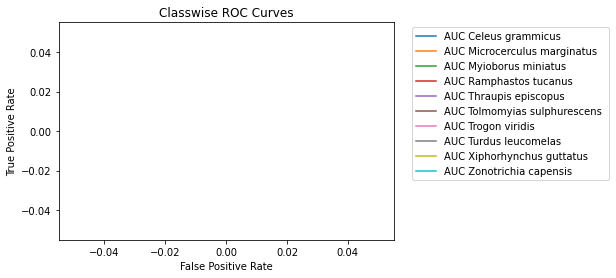

In [162]:
import matplotlib.pyplot as plt
for species in species_of_interests:
    fpr, tpr, thresh = roc_curve(label_df[species],  scores_df[species])
    auc = roc_auc_score(label_df[species],  preds_df[species])
    plt.plot(fpr,tpr,label="AUC " + species + " "+str(auc))

plt.title('Classwise ROC Curves')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.show()